In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm
import os
# 圆周距离函数
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
    dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
    return dis


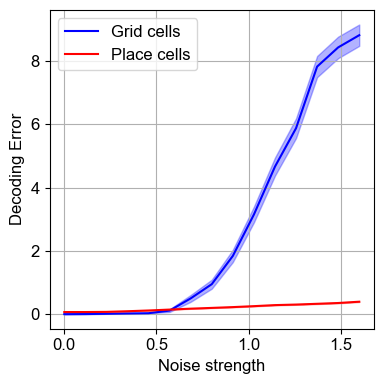

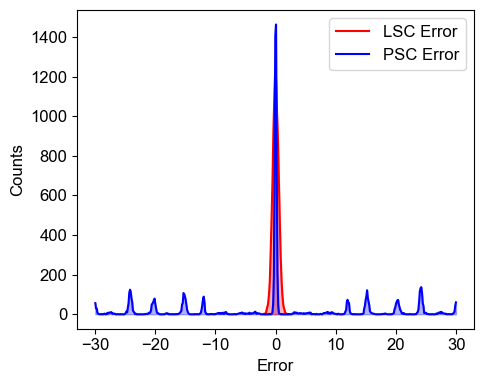

In [6]:
z_decode_psc_mean = np.load('results/cth/z_decode_psc_mean.npy')
z_decode_lsc_mean = np.load('results/cth/z_decode_lsc_mean.npy')
z_decode_psc_gop_mean = np.load('results/cth/z_decode_psc_gop_mean.npy')
z_decode_psc_std = np.load('results/cth/z_decode_psc_std.npy')
z_decode_lsc_std = np.load('results/cth/z_decode_lsc_std.npy')
z_decode_psc_gop_std = np.load('results/cth/z_decode_psc_gop_std.npy')

noise_stre = np.linspace(0,1.6,15)
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})
plt.figure(figsize=(4, 4))

plt.plot(noise_stre, z_decode_psc_mean, label='Grid cells', color='blue')
plt.fill_between(noise_stre, z_decode_psc_mean - z_decode_psc_std/30, z_decode_psc_mean + z_decode_psc_std/30, color='blue', alpha=0.3)

plt.plot(noise_stre, z_decode_lsc_mean*10, label='Place cells', color='red')
plt.fill_between(noise_stre, 10*z_decode_lsc_mean - 10*z_decode_lsc_std/30, 10*z_decode_lsc_mean + 10*z_decode_lsc_std/30, color='red', alpha=0.3)

plt.xlabel('Noise strength')
plt.ylabel('Decoding Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('figures_cth/Bayesian_integration.pdf')
plt.show()

z_decode_psc = np.load('results/cth/z_decode_psc_distribution.npy')
z_decode_lsc = np.load('results/cth/z_decode_lsc_distribution.npy')

error_psc = z_decode_psc - 30
error_lsc = z_decode_lsc - 30

# Compute the histogram for the PSC and LSC errors
counts_psc, bin_edges_psc = np.histogram(error_psc, bins=500)
counts_lsc, bin_edges_lsc = np.histogram(error_lsc*10, bins=500)

# Calculate the bin centers
bin_centers_psc = (bin_edges_psc[:-1] + bin_edges_psc[1:]) / 2
bin_centers_lsc = (bin_edges_lsc[:-1] + bin_edges_lsc[1:]) / 2

# Remove zero points
nonzero_indices_lsc = counts_lsc > 0
bin_centers_lsc = bin_centers_lsc[nonzero_indices_lsc]
counts_lsc = counts_lsc[nonzero_indices_lsc]

# Plot the histogram with non-zero points only
plt.figure(figsize=(5, 4))
plt.plot(bin_centers_lsc, counts_lsc, label='LSC Error', color='red')
plt.plot(bin_centers_psc, counts_psc, label='PSC Error', color='blue')

plt.fill_between(bin_centers_psc, counts_psc, color='blue', alpha=0.3)
plt.fill_between(bin_centers_lsc, counts_lsc, color='red', alpha=0.3)

plt.xlabel('Error')
plt.ylabel('Counts')
plt.legend()
plt.tight_layout()
plt.savefig('figures_cth/Non_local_error.pdf')
plt.show()


In [ ]:
import torch
from utils.ProbModel import position2phase_loglikelihood_modules_batch_MAP, PSC_fr_loglikelihood_modules_batch_MAP, LSC_fr_loglikelihood_batch_MAP, prior_function

def Simplified_PSC_MAP_decoder(PSCModel, activation_gs, n_pos=4000, n_phi=100, M=3):  
    '''
    MAP: Maximum A Posteriori
    activation_gs shape [M, n_g]
    '''
    L_env = 60
    ## parameter space
    phi_candidates = torch.linspace(-np.pi, np.pi, n_phi)
    z_candidates = torch.linspace(0, L_env, n_pos)
    phi_candidates_modules = phi_candidates[:,None].expand(-1,M) # shape [n_phi, M]
    fg_modules = PSCModel.forward_modules_batch(phi_candidates_modules) # shape [n_phi, M, n_g]
    log_likelihood_fr = PSC_fr_loglikelihood_modules_batch_MAP(activation_gs, fg_modules) # shape [n_phi, M]
    phi_decode_index = torch.argmax(log_likelihood_fr, axis=0)
    phi_decode = phi_candidates[phi_decode_index]
    # Second step: decode z
    prior = prior_function(phi_decode, z_candidates)
    # plt.plot(prior)
    z_est_index = torch.argmax(prior)
    z_decode = z_candidates[z_est_index]

    z_est = z_decode.detach().cpu().clone().numpy()
    phi_est = phi_decode.detach().cpu().clone().numpy()
    return z_est, phi_est